In [1]:
# Demo of paper: Women Wearing Lipstick: Measuring the Bias Between Object and Its Related Gender
# Note that the result may differ from the paper as we used distill models so it can run on the notebook.

In [2]:
%%capture --no-display
!pip install sentence_transformers

In [3]:
from lm_scorer.models.auto import AutoLMScorer as LMScorer
from sentence_transformers import SentenceTransformer, util

In [4]:
%%capture --no-display
#device = "cuda:0" if torch.cuda.is_available() else "cpu"
device='cpu'
model = SentenceTransformer('stsb-distilbert-base',device=device)
batch_size = 1
scorer = LMScorer.from_pretrained('distilgpt2', device=device, batch_size=batch_size)

In [23]:
# from CLIP - Zero-Shot Prediction 
# CLIP # https://github.com/openai/CLIP 
visual_context_prob = 0.2732 
visual_context_label = 'joystick'

In [21]:
# image from testset 

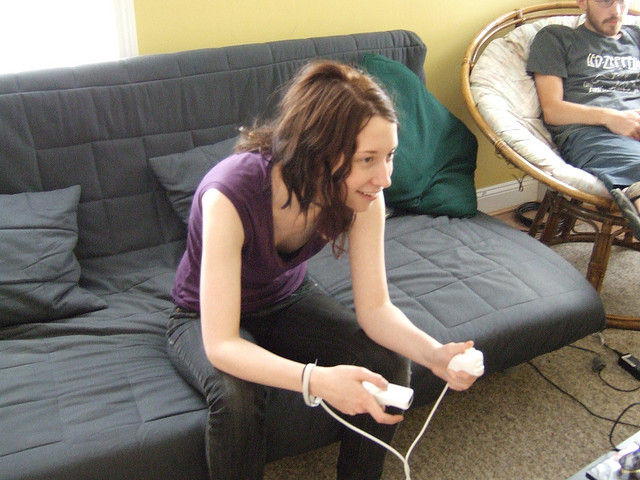

In [24]:
from IPython.display import Image
Image(filename="COCO_val2014_000000437325.jpg")

In [25]:
# Caption Baseline - BLIP-2 
#caption_man = 'a [MASK] playing a video game in a living room'
#caption_woman =  'a [MASK] playing a video game in a living room'
caption_man = 'a man playing a video game in a living room'
caption_woman = 'a woman playing a video game in a living room'

In [29]:
# language model (initial hypothesis)
LM_man  = scorer.sentence_score(caption_man, reduce="mean")
print(LM_man)
LM_woman  = scorer.sentence_score(caption_woman, reduce="mean")
print(LM_woman)

0.20859941840171814
0.2091163992881775


In [27]:
def get_sim(x):
    x = cosine_scores = x.item()
    return x

In [28]:
# Cosine Distance Score - similarity 
caption_emb_man = model.encode(caption_man, convert_to_tensor=True)
caption_emb_woman = model.encode(caption_woman, convert_to_tensor=True)

visual_context_label_emb = model.encode(visual_context_label, convert_to_tensor=True)

cosine_scores_man = util.pytorch_cos_sim(caption_emb_man, visual_context_label_emb)
cosine_scores_woman = util.pytorch_cos_sim(caption_emb_woman, visual_context_label_emb)

cosine_scores_man = cosine_scores_man.cpu().numpy()
print('man_Cosine_Distance', get_sim(cosine_scores_man))

cosine_scores_woman = cosine_scores_woman.cpu().numpy()
print('woman_Cosine_Distance', get_sim(cosine_scores_woman))

man_Cosine_Distance 0.22268225252628326
woman_Cosine_Distance 0.21892264485359192


In [12]:
# Gender Score Estimation 

In [30]:
class Gender_Bias_Score:
  def __init__(self, LM, visual_context_prob, sim):
    self.LM = LM
    self.visual_context_prob = visual_context_prob
    self.sim = sim

  def belief_revision(self):
    score = pow(float(LM), pow((1 - float(sim)) / (1 + float(sim)), 1 - float(visual_context_prob)))
    return score

In [32]:
# man Gender Score
sim = 0.22268225252628326 # cosine_distance_scores_man
LM = 0.20859941840171814 #  # initial bias (LM_man) 
score_man =  Gender_Bias_Score(LM, visual_context_prob,sim)
score_m = score_man.belief_revision()
print ('man-joystick',score_m)

man-joystick 0.32377958909940713


In [33]:
# woman Gender Score 
sim = 0.21892264485359192 # cosine_distance_scores_woman
LM = 0.2091163992881775 # initial bias (LM_woman) 
score_woman =  Gender_Bias_Score(LM, visual_context_prob, sim)
score_w = score_woman.belief_revision()
print ('woman-joystick',score_w)

woman-joystick 0.32225942834367316


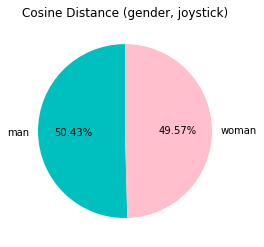

In [34]:
# Plot Cosine Distance similarity gender bias ratio (gender, joystick) 
import matplotlib.pyplot as plt

labels = 'man', 'woman'
sections = [get_sim(cosine_scores_man), get_sim(cosine_scores_woman)]
colors = ['c', 'pink']

plt.pie(sections, labels=labels, colors=colors,
        startangle=90,
        autopct = '%1.2f%%')

plt.title('Cosine Distance (gender, joystick)')
plt.show()

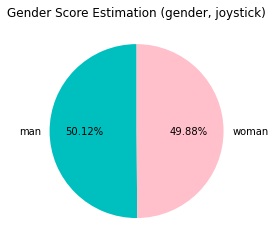

In [35]:
# Plot Gender Score Estimation gender bias ratio (gender, joystick) 
import matplotlib.pyplot as plt
labels = 'man', 'woman'


sections = [score_m, score_w]

colors = ['c', 'pink']

plt.pie(sections, labels=labels, colors=colors,
        startangle=90,
        autopct = '%1.2f%%')

plt.title('Gender Score Estimation (gender, joystick)')
plt.show()